# <font color="#964B00">Contexte</font>


Pour atteindre l'objectif de **ville neutre en émissions de carbone en 2050**, la ville de **Seattle** s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.


Dans cette partie nous cherchons à modéliser ou  prédire les **émissions de CO2** et la **consommation totale d’énergie** de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

## <font color = "596b00">Les variables cibles</font>  
* **<font color = "555D00">TotalGHGEmissions</font>** : émissions de CO2

* **<font color ="045C00"> SiteEnergyUseWN(kBtu)</font>** : consommation totale d’énergie

**Nous sommes en présence d'un cas d'apprentissage supervisé car la  variable cible est continue.**

Ainsi les modèles que nous utiliserons serons entre autre des **Modèles de régressions**

Nous aurons entre autre 4 modèles des modèles linéaire et non-linéaire 
 
**1. [Modèle Baseline : Régression linéaire multivariée](#section_1)**    
**2. [Modèle linéaires (#section_2)**
    
    2.2. [Modèle Support Vector Regression (SVM)](#section_2_1)     

    
**3. [Modèle non-linéaires : XGBoost et RandomForestRegressor](#section_3)**    
    3.1. [Modèle RandomForestRegressor](#section_3_1)     
    3.2. [Modèle XGBoost *(eXtreme Gradient Boosting)*](#section_3_2) 
    3.3. CNN 
la régession linéaire multivariée dans ce cas sert de point de référence pour évaluer les performances des modèles plus complexes 

# Importation de pakage

In [1]:
import pandas as pd
import numpy as np
#%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
#import sante as s
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
#from termcolor import colored
import math
from scipy import stats
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#from sklearn.impute import KNNImputer
#from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor

#Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 1)

In [2]:
#import batiment as b

In [3]:
import bat as bt 

## Préparation des données 

In [42]:
df = pd.read_csv('2016_Building_Energy_Benchmarking.csv', sep = ",") 


### Suppression des colonnes inutiles 

In [43]:
data = bt.variable_to_drop(df)

In [44]:
data.shape

(995, 26)

In [7]:
data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'Latitude',
       'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(therms)', 'DefaultData', 'ComplianceStatus',
       'TotalGHGEmissions'],
      dtype='object')

### âge des bâtiemnts

In [45]:
# Calculer l'âge en soustrayant chaque valeur de YearBuilt de 2016
data['Age'] = 2016 - data['YearBuilt']

# Réorganiser les colonnes pour placer "Age" avant "YearBuilt"
df = data[['Age'] + [col for col in data.columns if col != 'Age' and col != 'YearBuilt']]

In [46]:
numerical_features = data.select_dtypes(include=['int64','float64'])
categorical_features = data.select_dtypes(exclude=['int64','float64'])

# Emisssion de co2

### preprocessing 

In [47]:
#moi
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

numerical_features =['Age',  'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'LargestPropertyUseTypeGFA',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'ENERGYSTARScore','TotalGHGEmissions']
categorical_features = ['BuildingType', 'PrimaryPropertyType','Neighborhood',
       'LargestPropertyUseType','ComplianceStatus']
    
variables_to_remove = ['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)'] 
for variable in variables_to_remove:
    numerical_features.remove(variable)

X_train = train_data[numerical_features +categorical_features]
y_train = train_data['TotalGHGEmissions']
X_test = test_data[numerical_features +categorical_features]
y_test = test_data['TotalGHGEmissions']
print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 796 lignes,
Test: 199 lignes.



### prétraitement des variables catégorielles 

In [48]:


# Définir les étapes de prétraitement pour les variables numériques et catégorielles
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))  # Vous pouvez remplacer 'mean' par 'median', 'most_frequent', etc.
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputation des valeurs manquantes par la valeur la plus fréquente
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# Créer un préprocesseur pour appliquer les étapes de prétraitement à chaque type de colonne
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features[:-1])  # Exclure la variable cible
    ])

# Adapter le préprocesseur aux données d'entraînement et transformer les données
X_train_final = preprocessor.fit_transform(train_data)
X_test_final = preprocessor.transform(test_data)


C:\ProgramData\anaconda\envs\Formation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### caractéristiques après le prétraitement

In [49]:
# Obtenir les noms des caractéristiques après le prétraitement
feature_names = preprocessor.get_feature_names_out()

# Afficher les noms des caractéristiques
#print(feature_names)

# Modèle Baseline : Régression linéaire multivariée    


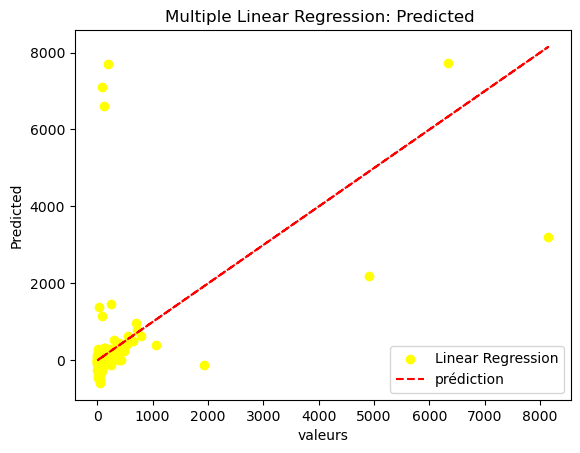

RMSE: 989.8869555296833
MAE: 285.27246619545514
R²: -0.4749844955158036


In [13]:

rmse, mae, r2 = bt.multiple_regression(X_train_final, X_test_final, y_train, y_test)

# Affichage des résultats
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)


Nous utiliserons les métiques suivantes:
    * Erreur quadratique moyenne (RMSE) 

* Erreur absolue moyenne (MAE)

* Coefficient de détermination (R²)

* Erreur relative moyenne (MRE) :

* Erreur de prédiction maximale (Max Error) 
* Écart type des scores de validation croisée
* MAE moyenne lors de la validation croisée
* R² moyen lors de la validation croisée

### SVM

Métriques pour le SVM:
R² moyen lors de la validation croisée: -0.05287894060863776
MAE moyenne lors de la validation croisée: 166.71976808070923


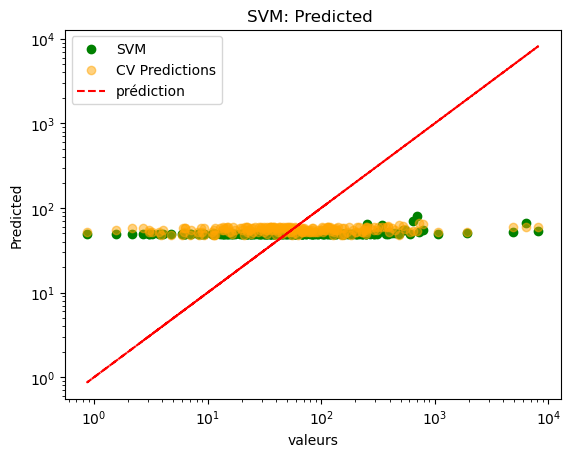

In [14]:
svm = bt.svm_regression(X_train_final, X_test_final, y_train, y_test)


# Modèle non linéaire 

## RandomForestRegressor

Métriques pour le Random Forest:
R²: 0.12885216681764977
MAE: 190.43538442211047
RMSE: 760.7427182693496
Median Absolute Error: 27.881300000000024
Max Error: 5530.4217999999955
R² moyen lors de la validation croisée: 0.5928811657075921
Écart type des scores de validation croisée: 0.28622417689450075
MAE moyenne lors de la validation croisée: 109.31579675943397


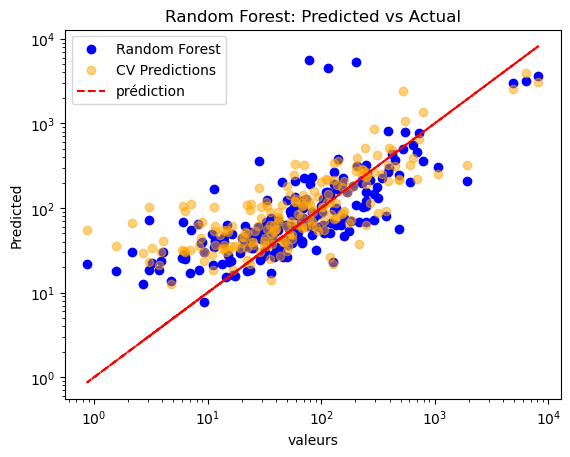

In [15]:
 foret_aléatoire = bt.random_forest_regression(X_train_final, X_test_final, y_train, y_test)


## xgboost

Métriques pour XGBoost:
R²: -5.764736816962548
MAE: 383.3410929395805
RMSE: 2119.9095248201584
Median Absolute Error: 28.599977874755858
Max Error: 16631.558046875
R² moyen lors de la validation croisée: -0.8820806911744639
Écart type des scores de validation croisée: 1.6649721701909388
MAE moyenne lors de la validation croisée: 122.96171418305201


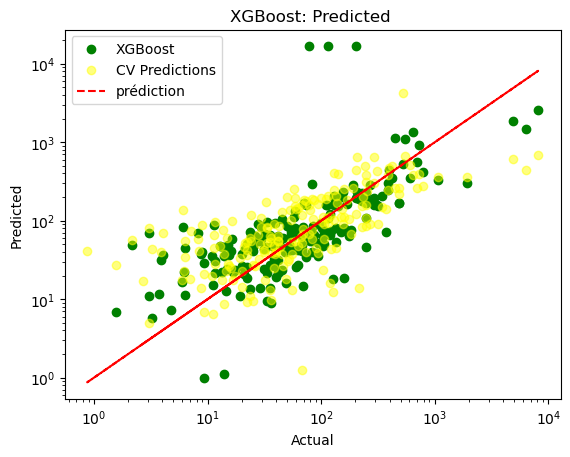

In [16]:
xgboost =  bt.xgboost_regression(X_train_final, X_test_final, y_train, y_test)


In [17]:
## cnn

C:\ProgramData\anaconda\envs\Formation\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Métriques pour le réseau de neurones:
R²: -7.994175589087758
MAE: 607.4165222857465
RMSE: 2444.4015734106356


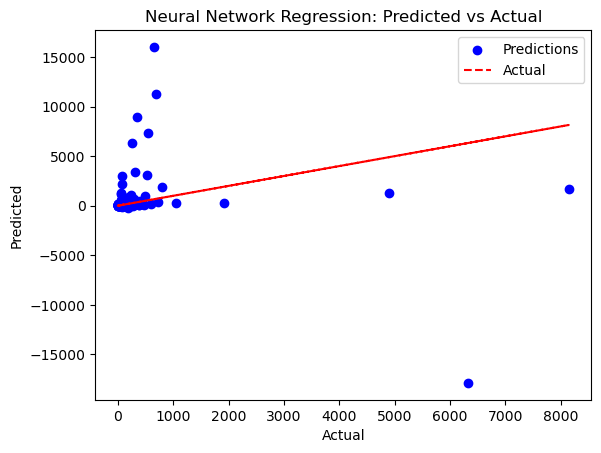

In [18]:
cnn =  bt.neural_network_regression(X_train_final, X_test_final, y_train, y_test)


## feature importance pour la foret aléatoire 

Métriques pour le Random Forest:
R²: 0.12885216681764977
MAE: 190.43538442211047
RMSE: 760.7427182693496
Median Absolute Error: 27.881300000000024
Max Error: 5530.4217999999955
R² moyen lors de la validation croisée: 0.5928811657075921
Écart type des scores de validation croisée: 0.28622417689450075
MAE moyenne lors de la validation croisée: 109.31579675943397


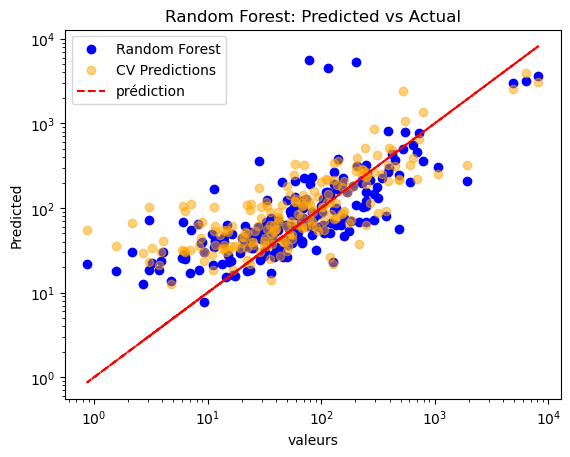

In [19]:
result = bt.random_forest_regression(X_train_final, X_test_final, y_train, y_test)

forest_model = result[0]
forest_y_pred = result[1]
forest_y_cv_pred = result[2]

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [21]:
feature_names = preprocessor.get_feature_names_out()

# Afficher les noms des caractéristiques
print(feature_names)

['num__Age' 'num__Latitude' 'num__Longitude' 'num__NumberofBuildings'
 'num__NumberofFloors' 'num__PropertyGFATotal'
 'num__LargestPropertyUseTypeGFA' 'num__SteamUse(kBtu)'
 'num__ENERGYSTARScore' 'cat__BuildingType_Campus'
 'cat__BuildingType_NonResidential' 'cat__BuildingType_Nonresidential COS'
 'cat__BuildingType_SPS-District K-12'
 'cat__PrimaryPropertyType_Distribution Center'
 'cat__PrimaryPropertyType_Hospital' 'cat__PrimaryPropertyType_Hotel'
 'cat__PrimaryPropertyType_K-12 School'
 'cat__PrimaryPropertyType_Large Office'
 'cat__PrimaryPropertyType_Low-Rise Multifamily'
 'cat__PrimaryPropertyType_Medical Office'
 'cat__PrimaryPropertyType_Mixed Use Property'
 'cat__PrimaryPropertyType_Other'
 'cat__PrimaryPropertyType_Refrigerated Warehouse'
 'cat__PrimaryPropertyType_Residence Hall'
 'cat__PrimaryPropertyType_Retail Store'
 'cat__PrimaryPropertyType_Senior Care Community'
 'cat__PrimaryPropertyType_Small- and Mid-Sized Office'
 'cat__PrimaryPropertyType_Supermarket / Grocery 

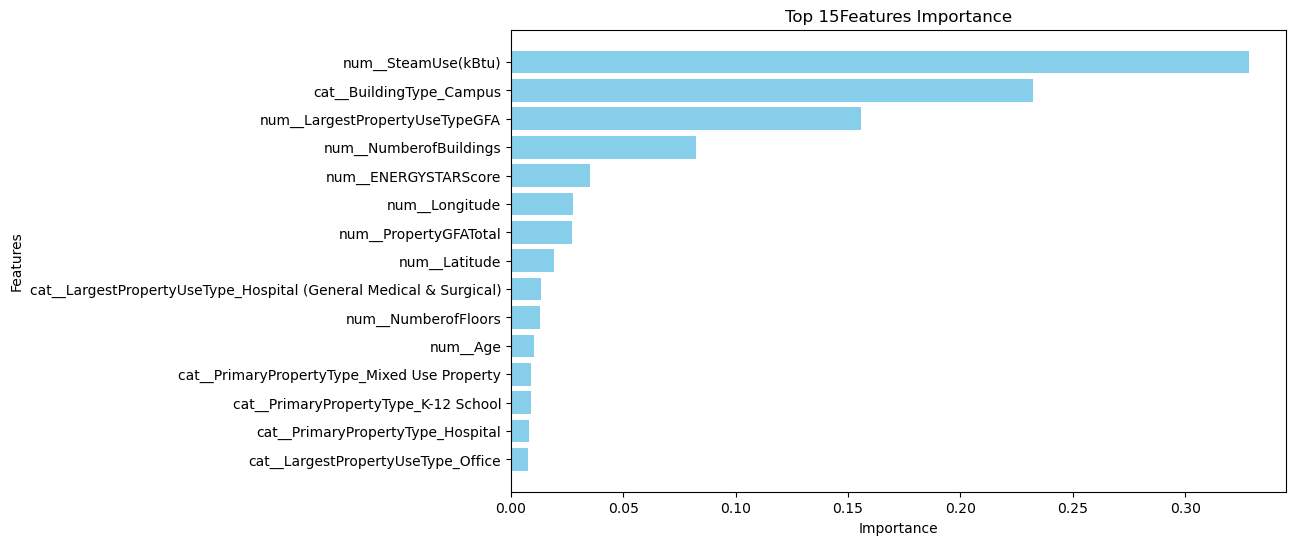

(RandomForestRegressor(random_state=42),
 array([4457.3759,   54.2496,   67.8114,   16.2624,   68.4916,   31.6292,
          83.1376,   38.0649,  123.4907,   17.0952,   26.3472,   27.6763,
          43.965 ,   39.2453,  263.34  ,   60.9385,   53.9993,  380.6497,
         499.3331,   55.9837,   17.8794,   62.0092,   62.3481,   80.453 ,
          51.2555,  141.7046,   56.5712,   48.363 ,  354.8864,  313.8151,
         154.2944,   89.4975,  133.963 ,   49.2204,   63.6793,   36.4397,
          65.7665,   26.2088,   72.2325,   61.829 ,  214.5031,  121.0419,
          26.477 ,  108.9192,   59.5089,  122.1413,  198.5231,   31.3784,
         548.7674,   27.8621,   22.7732,   18.6921,   26.8121,   23.6518,
          62.9948,   85.5451,   90.9408,   61.5331,   59.145 ,   78.2727,
         209.7356,   18.4407,  189.7779,  294.3902,  128.3187,   39.4115,
          22.2052,   64.3373,  462.5365,  193.3004,   35.0878,  200.7474,
          33.4361,   31.6577,   40.3052,   89.6959,   22.0708,   76.771

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

def random_forest_regression(X_train_final, X_test_final, y_train, y_test, feature_names):
    """
    Effectue la régression avec un modèle de forêt aléatoire.

    Args:
        X_train_final  Les caractéristiques (features) de l'ensemble d'entraînement.
        X_test_final Les caractéristiques (features) de l'ensemble de test.
        y_train : Les valeurs cibles de l'ensemble d'entraînement.
        y_test : Les valeurs cibles de l'ensemble de test.
        feature_names: Les noms des caractéristiques.

    Returns:
        tuple: Un tuple contenant:
            - RandomForestRegressor: Le modèle de forêt aléatoire entraîné.
            - array-like: Les prédictions sur l'ensemble de test.
            - array-like: Les prédictions de validation croisée.
            - float: Erreur quadratique moyenne (RMSE).
            - float: Erreur absolue moyenne (MAE).
            - float: Coefficient de détermination (R²).
            - float: Erreur absolue médiane.
            - float: Erreur de prédiction maximale (Max Error).
            - float: Écart type des scores de validation croisée.
            - float: MAE moyenne lors de la validation croisée.
            - float: R² moyen lors de la validation croisée.
            - list: Les noms des 10 caractéristiques les plus importantes.
    """
        
    # Créer et entraîner le modèle de Random Forest
    forest_regressor = RandomForestRegressor(random_state=42)
    forest_regressor.fit(X_train_final, y_train)

    # Faire des prédictions sur l'ensemble de test
    y_pred = forest_regressor.predict(X_test_final)

    # Calculer les métriques de performance
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    median_ae = median_absolute_error(y_test, y_pred)
    max_err = np.max(np.abs(y_test - y_pred))  # Calcul de l'erreur maximale

    # Validation croisée avec R²
    cv_scores = cross_val_score(forest_regressor, X_train_final, y_train, cv=5, scoring='r2')
    cv_mean_r2 = cv_scores.mean()
    cv_std_r2 = cv_scores.std()
    cv_mean_mae = -cross_val_score(forest_regressor, X_train_final, y_train, cv=5, scoring='neg_mean_absolute_error').mean()

    # Afficher les 10 fonctionnalités les plus importantes
    feature_importance = forest_regressor.feature_importances_
    sorted_indices = np.argsort(feature_importance)[::-1]
    top_feature_indices = sorted_indices[:15]
    top_feature_names = [feature_names[i] for i in top_feature_indices]
    top_feature_importance = feature_importance[top_feature_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(top_feature_names, top_feature_importance, color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Top 15Features Importance')
    plt.savefig('feature importance.png')

    plt.gca().invert_yaxis()
    plt.show()

    return (forest_regressor, y_pred, cv_scores, rmse, mae, r2, median_ae, max_err, cv_std_r2, cv_mean_mae, cv_mean_r2, top_feature_names)

# Appel de la fonction
# Supposons que vous avez un array `feature_names` contenant les noms de vos caractéristiques
random_forest_regression(X_train_final, X_test_final, y_train, y_test, feature_names)


In [23]:
## recherche  des hyperparamtre

* Ici on Trouve les hyperparamètres optimaux pour votre modèle de forêt aléatoire car il est  crucial pour obtenir de bonnes performances prédictives. Les hyperparamètres sont des paramètres du modèle qui ne sont pas appris directement à partir des données mais qui influent sur la manière dont le modèle est entraîné. Pour trouver les meilleurs hyperparamètres, vous pouvez utiliser des techniques d'optimisation telles que la recherche par grille ou la recherche aléatoire.  on utilisera 

**Recherche par grille (Grid Search)** 

* spécifier une grille d'hyperparamètres que vous souhaitez explorer.
* entraîner et évaluez le modèle pour chaque combinaison d'hyperparamètres.
* sélectionner les hyperparamètres qui donnent les meilleures performances.
Scikit-learn fournit la classe GridSearchCV pour effectuer cette recherche de manière efficace.

In [24]:
# (Grid Search

In [25]:
from sklearn.model_selection import GridSearchCV

# Définir la grille des hyperparamètres à explorer
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Créer le modèle de forêt aléatoire
forest_regressor = RandomForestRegressor(random_state=42)

# Instancier l'objet GridSearchCV
grid_search = GridSearchCV(forest_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

# Exécuter la recherche sur la grille
grid_search.fit(X_train_final, y_train)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres:", grid_search.best_params_)

# Obtenir le meilleur modèle
best_model = grid_search.best_estimator_

# Évaluer le meilleur modèle sur l'ensemble de test
y_pred_best = best_model.predict(X_test_final)
best_rmse = mean_squared_error(y_test, y_pred_best, squared=False)
print("RMSE du meilleur modèle:", best_rmse)


Meilleurs hyperparamètres: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
RMSE du meilleur modèle: 432.7019301324417


In [26]:
### INterpretation 

n_estimators : Le nombre d'estimateurs (arbres) dans la forêt est fixé à 100. Cela signifie que le modèle utilise 100 arbres pour construire l'ensemble. Dans ce cas, l'effet du nombre d'estimateurs sur le RMSE a été évalué, et 100 arbres ont donné le meilleur résultat parmi les valeurs testées.

max_depth : La profondeur maximale des arbres n'est pas limitée (max_depth=None). Cela signifie que les arbres sont développés jusqu'à ce que toutes les feuilles soient pures ou jusqu'à ce que toutes les feuilles contiennent le nombre minimum d'échantillons requis. Cela peut potentiellement conduire à des arbres très profonds et à un risque accru de surajustement. Cependant, dans ce cas, cela semble avoir donné de bons résultats.

min_samples_split : Le nombre minimum d'échantillons requis pour diviser un nœud interne est fixé à 2. Cela signifie qu'un nœud doit contenir au moins 2 échantillons pour qu'une division soit considérée. Une valeur faible comme celle-ci peut conduire à des arbres plus complexes, ce qui peut potentiellement augmenter le risque de surajustement.

min_samples_leaf : Le nombre minimum d'échantillons requis pour être à une feuille est fixé à 1. Cela signifie qu'une feuille peut contenir un seul échantillon. Encore une fois, une valeur faible comme celle-ci peut conduire à des arbres plus complexes et à un risque accru de surajustement.

Le RMSE associé au meilleur modèle est de 872.9976292617645. Cela signifie que, en moyenne, les prédictions du modèle sont à environ 872.99 unités de la véritable valeur cible. Plus le RMSE est faible, meilleures sont les performances du modèle. Il est important de noter que ces résultats peuvent varier en fonction de la nature spécifique de vos données et de votre problème de modélisation.

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Utiliser les meilleurs hyperparamètres
best_hyperparameters = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

# Créer un nouveau modèle de forêt aléatoire avec les meilleurs hyperparamètres
best_forest_regressor = RandomForestRegressor(**best_hyperparameters, random_state=42)

# Entraîner le modèle sur l'ensemble d'entraînement complet
best_forest_regressor.fit(X_train_final, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_best = best_forest_regressor.predict(X_test_final)

# Calculer le RMSE du meilleur modèle
best_rmse = mean_squared_error(y_test, y_pred_best, squared=False)
print("RMSE du meilleur modèle:", best_rmse)


RMSE du meilleur modèle: 760.7427182693496



Si le RMSE obtenu après la recherche sur grille (Grid Search) est le même que celui du modèle avant la recherche sur grille, cela peut être dû à plusieurs raisons possibles :

Les hyperparamètres par défaut sont déjà optimaux : Il est possible que les valeurs par défaut des hyperparamètres de RandomForestRegressor fonctionnent bien pour votre ensemble de données particulier. Dans ce cas, la recherche sur grille n'a pas amélioré les performances du modèle car les paramètres par défaut étaient déjà optimaux.

Espace de recherche restreint : La grille d'hyperparamètres que vous avez spécifiée dans la recherche sur grille peut ne pas avoir exploré un espace de recherche suffisamment large. Si la grille ne couvre pas une gamme suffisamment large d'hyperparamètres, il est possible que la recherche ne trouve pas de combinaison d'hyperparamètres qui améliore significativement les performances par rapport aux paramètres par défaut.

Limitations de la métrique de performance : La métrique de performance que vous avez utilisée pour évaluer les modèles peut ne pas être sensible à de petites améliorations dans les performances du modèle. Par exemple, si vous avez utilisé RMSE comme métrique de performance et que les différences entre les modèles sont très petites, vous pourriez obtenir des valeurs de RMSE similaires.

Surajustement : Il est également possible que votre modèle soit surajusté (overfitted) aux données d'entraînement, ce qui signifie qu'il fonctionne bien sur l'ensemble d'entraînement mais moins bien sur l'ensemble de test. Dans ce cas, l'optimisation des hyperparamètres n'améliorera pas nécessairement les performances du modèle sur l'ensemble de test.

Pour vérifier si la recherche sur grille a réellement amélioré les performances du modèle, vous pouvez comparer les scores de validation croisée obtenus avec les différents jeux d'hyperparamètres et utiliser des méthodes telles que la validation croisée pour évaluer les performances du modèle.






In [28]:
## on essaie a nouveau avce d'autres parametres

In [29]:
Métriques pour le Random Forest:
R²: -0.14720856644450242
MAE: 207.1244155778894
RMSE: 872.9976292617645
Median Absolute Error: 30.460800000000056
Max Error: 6708.764099999994
R² moyen lors de la validation croisée: 0.5974405614437698
Écart type des scores de validation croisée: 0.2827689942068145
MAE moyenne lors de la validation croisée: 107.93653768003146; Métriques pour XGBoost:
R²: -5.745620137174757
MAE: 381.6547302047691
RMSE: 2116.9120465849956
Median Absolute Error: 28.831766357421884
Max Error: 16604.655703125
R² moyen lors de la validation croisée: -0.8965431611997913
Écart type des scores de validation croisée: 1.6500035425086002
MAE moyenne lors de la validation croisée: 125.94771641765556

SyntaxError: invalid character '²' (U+00B2) (1573577569.py, line 2)

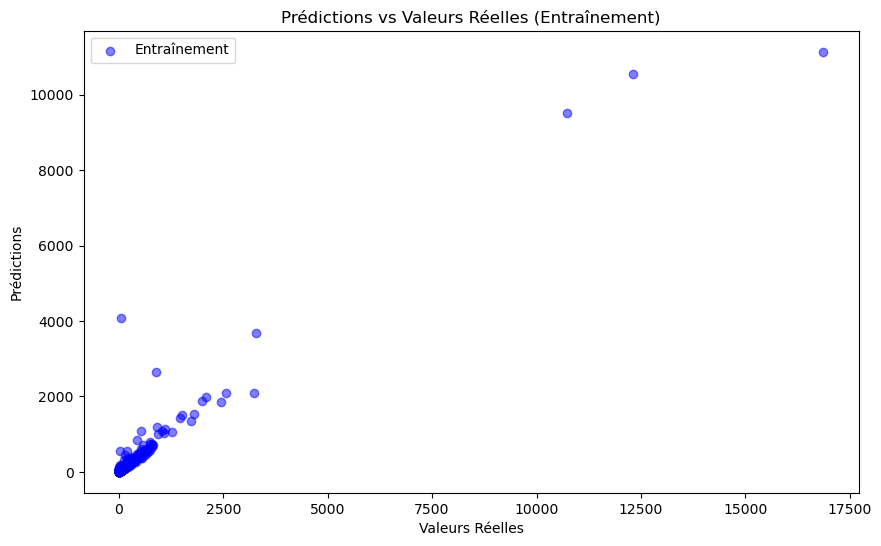

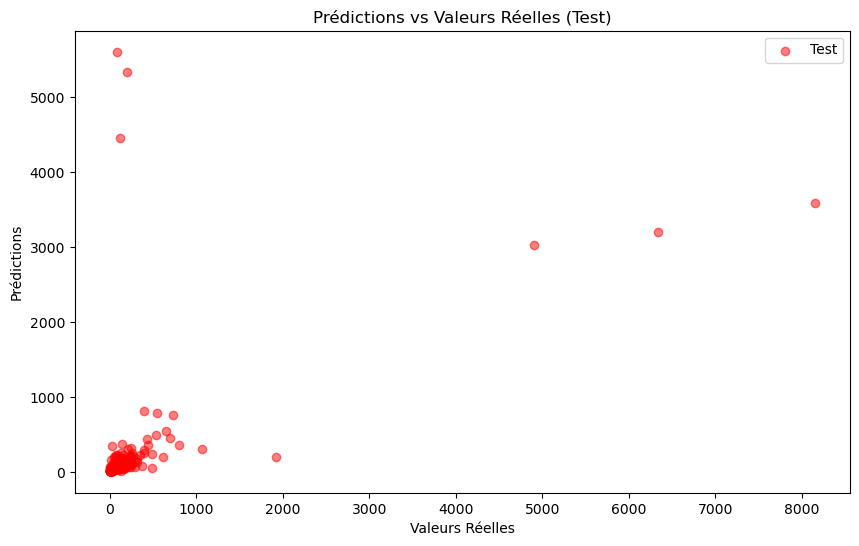

In [30]:
import matplotlib.pyplot as plt

# Plot des prédictions sur l'ensemble d'entraînement
plt.figure(figsize=(10, 6))
plt.scatter(y_train, best_forest_regressor.predict(X_train_final), color='blue', label='Entraînement', alpha=0.5)
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs Réelles (Entraînement)')
plt.legend()
plt.show()

# Plot des prédictions sur l'ensemble de test
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, color='red', label='Test', alpha=0.5)
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.savefig('Prédictions.png')

plt.title('Prédictions vs Valeurs Réelles (Test)')
plt.legend()
plt.show()


In [ ]:
##shape

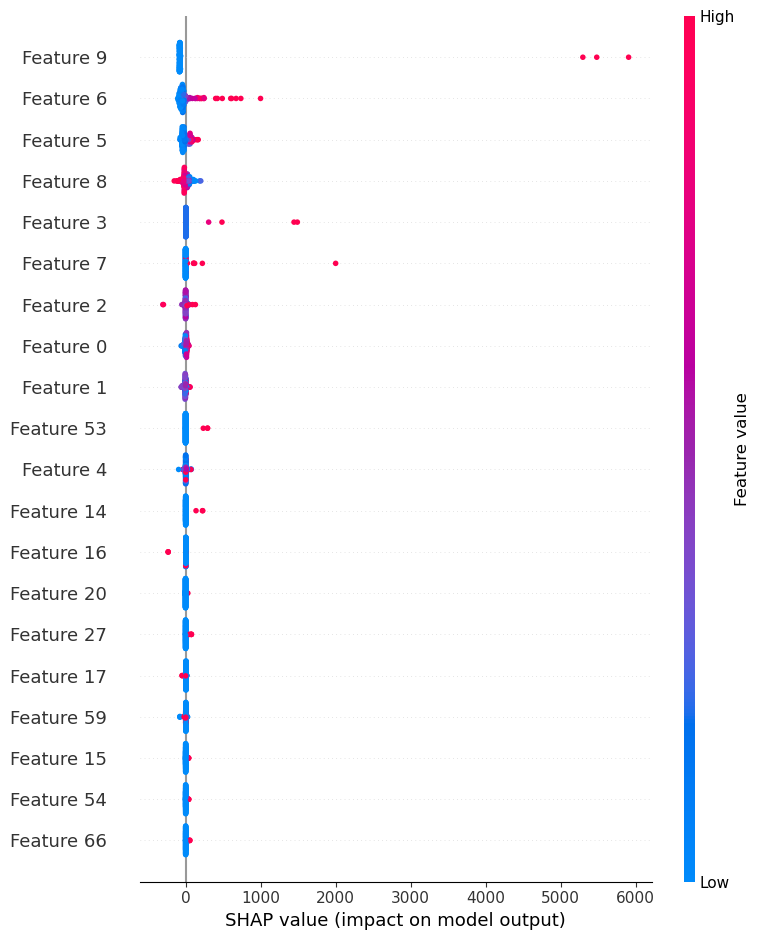

In [31]:
import shap

# Initialiser l'explaineur SHAP avec le modèle entraîné
explainer = shap.Explainer(best_forest_regressor, X_train_final)

# Calculer les valeurs SHAP pour l'ensemble de test
shap_values = explainer(X_test_final)

# Résumé des valeurs SHAP
shap.summary_plot(shap_values, X_test_final)


In [32]:
# Obtenez les valeurs SHAP pour chaque fonctionnalité
shap_feature_values = shap_values.values

# Afficher les valeurs SHAP pour chaque fonctionnalité
print("Valeurs SHAP pour chaque fonctionnalité:")
print(shap_feature_values)


Valeurs SHAP pour chaque fonctionnalité:
[[ 3.13972905e+01 -5.76109600e+01 -2.98064277e+02 ... -5.71315986e-01
   0.00000000e+00 -1.77796237e-02]
 [ 9.90263488e+00  4.00435163e-01 -2.73222538e+00 ... -1.63811446e+00
   0.00000000e+00 -2.54354932e-02]
 [ 1.75846608e+00 -9.88010475e+00 -2.84313864e+00 ... -1.81040927e+00
   0.00000000e+00  8.06635321e-01]
 ...
 [ 3.20968179e+01  5.72237294e+01  8.92477258e+01 ... -5.04815521e-01
   0.00000000e+00 -1.80322170e-02]
 [ 1.67472046e+01 -7.89044047e+00 -1.73823225e+00 ... -1.67880639e+00
   0.00000000e+00 -2.55764918e-02]
 [-3.11576542e+00  5.57914553e+00  6.68071017e+00 ... -1.91630979e+00
   0.00000000e+00 -3.24299513e-02]]


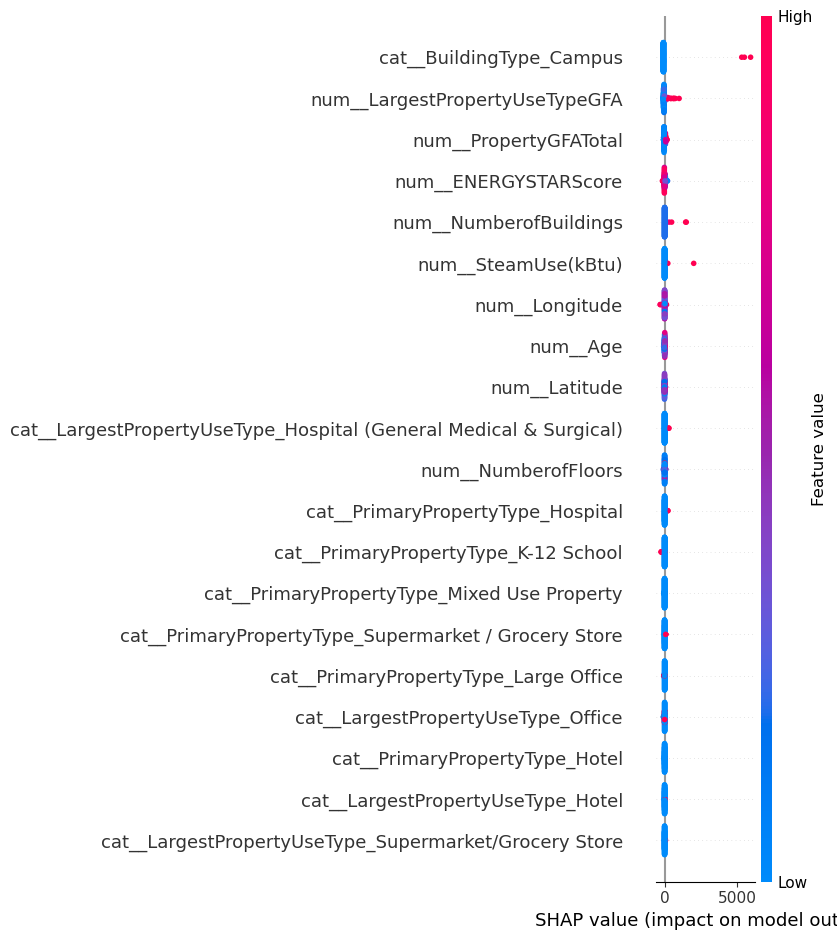

In [33]:
import shap

def random_forest_regression_shap(X_train_final, X_test_final, y_train, y_test, feature_names):
    # Créer et entraîner le modèle de Random Forest
    forest_regressor = RandomForestRegressor(random_state=42)
    forest_regressor.fit(X_train_final, y_train)

    # Expliquer les prédictions avec SHAP
    explainer = shap.Explainer(forest_regressor, X_train_final)
    shap_values = explainer(X_test_final)

    # Sauvegarder le plot SHAP
    shap.summary_plot(shap_values, X_test_final, feature_names=feature_names, show=False)
    plt.savefig('shap_summary_plot.png')  # Sauvegarde l'image

    return forest_regressor, shap_values

# Appel de la fonction
# Sup noms de vos caractéristiques
model, shap_values = random_forest_regression_shap(X_train_final, X_test_final, y_train, y_test, feature_names)


In [ ]:
# Obtenir les noms des fonctionnalités à partir de l'objet explainer
feature_names_shap = shap.TreeExplainer(model).feature_names
feature_names_shap

In [ ]:
## graphique de dépendance partielle pour analyser l'influence des varables sur les autres 

## influence de la variables ENERGYSTARScore

In [34]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

numerical_features = ['Age', 'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors',
                      'PropertyGFATotal', 'LargestPropertyUseTypeGFA',
                      'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)']
categorical_features = ['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType', 'ComplianceStatus']

variables_to_remove = ['ENERGYSTARScore'] 
numerical_features = [feature for feature in numerical_features if feature not in variables_to_remove]

X_train = train_data[numerical_features + categorical_features]
y_train = train_data['ENERGYSTARScore']
X_test = test_data[numerical_features + categorical_features]
y_test = test_data['ENERGYSTARScore']

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0], X_test.shape[0]))


Entrainement: 796 lignes,
Test: 199 lignes.



In [35]:


# Définir les étapes de prétraitement pour les variables numériques et catégorielles
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))  # Vous pouvez remplacer 'mean' par 'median', 'most_frequent', etc.
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputation des valeurs manquantes par la valeur la plus fréquente
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# Créer un préprocesseur pour appliquer les étapes de prétraitement à chaque type de colonne
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features[:-1])  # Exclure la variable cible
    ])

# Adapter le préprocesseur aux données d'entraînement et transformer les données
X_train_final = preprocessor.fit_transform(train_data)
X_test_final = preprocessor.transform(test_data)


C:\ProgramData\anaconda\envs\Formation\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [36]:
feature_names = preprocessor.get_feature_names_out()

# Afficher les noms des caractéristiques
#print(feature_names)

In [37]:
def random_forest_regression(
    X_train_final, X_test_final, y_train, y_test):
    """
    Effectue la régression avec un modèle de forêt aléatoire.

    Args:
        X_train_final  Les caractéristiques (features) de l'ensemble d'entraînement.
        X_test_final Les caractéristiques (features) de l'ensemble de test.
        y_train : Les valeurs cibles de l'ensemble d'entraînement.
        y_test : Les valeurs cibles de l'ensemble de test.

    Returns:
        tuple: Un tuple contenant:
            - RandomForestRegressor: Le modèle de forêt aléatoire entraîné.
            - array-like: Les prédictions sur l'ensemble de test.
            - array-like: Les prédictions de validation croisée.
            - float: Erreur quadratique moyenne (RMSE).
            - float: Erreur absolue moyenne (MAE).
            - float: Coefficient de détermination (R²).
            - float: Erreur absolue médiane.
            - float: Erreur de prédiction maximale (Max Error).
            - float: Écart type des scores de validation croisée.
            - float: MAE moyenne lors de la validation croisée.
            - float: R² moyen lors de la validation croisée.
    """
        
    # Créer et entraîner le modèle de Random Forest
    forest_regressor = RandomForestRegressor(random_state=42)
    forest_regressor.fit(X_train_final, y_train)

    # Faire des prédictions sur l'ensemble de test
    y_pred = forest_regressor.predict(X_test_final)

    # Calculer les métriques de performance
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    median_ae = median_absolute_error(y_test, y_pred)
    max_err = max_error(y_test, y_pred)

    print("Métriques pour le Random Forest:")
    print("R²:", r2)
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("Median Absolute Error:", median_ae)
    print("Max Error:", max_err)

    # Validation croisée avec R²
    cv_scores = cross_val_score(forest_regressor, X_train_final, y_train, cv=5, scoring='r2')
    print("R² moyen lors de la validation croisée:", cv_scores.mean())

    # Calculer l'écart type après la validation croisée
    std_cv_scores = np.std(cv_scores)
    print("Écart type des scores de validation croisée:", std_cv_scores)

    # Calculer la MAE de la cross-validation
    mae_cv = -cross_val_score(forest_regressor, X_train_final, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
    print("MAE moyenne lors de la validation croisée:", mae_cv)

    # Calculer les prédictions avec la validation croisée
    y_cv_pred = cross_val_predict(forest_regressor, X_test_final, y_test, cv=5)

    # Scatter plot pour le Random Forest
    plt.scatter(y_test, y_pred, label='Random Forest', color='blue')
    plt.scatter(y_test, y_cv_pred, label='CV Predictions', color='orange', alpha=0.5) # #     Prédictions de validation croisée
    plt.plot(y_test, y_test, color='red', linestyle='--', label='Actual')
    plt.xlabel('Actual')
   # plt.xscale("log")
   # plt.yscale('log')
    plt.ylabel('Predicted')
    plt.title('Random Forest: Predicted vs Actual pour la performance énergetique')
    plt.legend()

    plt.savefig('randomforestergie.png')
    plt.show()

    return forest_regressor, y_pred, y_cv_pred, rmse, mae, r2, median_ae, max_err, std_cv_scores, mae_cv, cv_scores.mean()


from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [38]:
 foret_aléatoire = random_forest_regression(X_train_final, X_test_final, y_train, y_test)


NameError: name 'max_error' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

def random_forest_regression(X_train_final, X_test_final, y_train, y_test, feature_names):
    """
    Effectue la régression avec un modèle de forêt aléatoire.

    Args:
        X_train_final  Les caractéristiques (features) de l'ensemble d'entraînement.
        X_test_final Les caractéristiques (features) de l'ensemble de test.
        y_train : Les valeurs cibles de l'ensemble d'entraînement.
        y_test : Les valeurs cibles de l'ensemble de test.
        feature_names: Les noms des caractéristiques.

    Returns:
        tuple: Un tuple contenant:
            - RandomForestRegressor: Le modèle de forêt aléatoire entraîné.
            - array-like: Les prédictions sur l'ensemble de test.
            - array-like: Les prédictions de validation croisée.
            - float: Erreur quadratique moyenne (RMSE).
            - float: Erreur absolue moyenne (MAE).
            - float: Coefficient de détermination (R²).
            - float: Erreur absolue médiane.
            - float: Erreur de prédiction maximale (Max Error).
            - float: Écart type des scores de validation croisée.
            - float: MAE moyenne lors de la validation croisée.
            - float: R² moyen lors de la validation croisée.
            - list: Les noms des 10 caractéristiques les plus importantes.
    """
        
    # Créer et entraîner le modèle de Random Forest
    forest_regressor = RandomForestRegressor(random_state=42)
    forest_regressor.fit(X_train_final, y_train)

    # Faire des prédictions sur l'ensemble de test
    y_pred = forest_regressor.predict(X_test_final)

    # Calculer les métriques de performance
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    median_ae = median_absolute_error(y_test, y_pred)
    max_err = np.max(np.abs(y_test - y_pred))  # Calcul de l'erreur maximale

    # Validation croisée avec R²
    cv_scores = cross_val_score(forest_regressor, X_train_final, y_train, cv=5, scoring='r2')
    cv_mean_r2 = cv_scores.mean()
    cv_std_r2 = cv_scores.std()
    cv_mean_mae = -cross_val_score(forest_regressor, X_train_final, y_train, cv=5, scoring='neg_mean_absolute_error').mean()

    # Afficher les 10 fonctionnalités les plus importantes
    feature_importance = forest_regressor.feature_importances_
    sorted_indices = np.argsort(feature_importance)[::-1]
    top_feature_indices = sorted_indices[:15]
    top_feature_names = [feature_names[i] for i in top_feature_indices]
    top_feature_importance = feature_importance[top_feature_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(top_feature_names, top_feature_importance, color='green')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Top 15Features Importance')
    plt.savefig('importance.png')

    plt.gca().invert_yaxis()
    plt.show()

    return (forest_regressor, y_pred, cv_scores, rmse, mae, r2, median_ae, max_err, cv_std_r2, cv_mean_mae, cv_mean_r2, top_feature_names)

# Appel de la fonction
# Supposons que vous avez un array `feature_names` contenant les noms de vos caractéristiques
random_forest_regression(X_train_final, X_test_final, y_train, y_test, feature_names)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.model_selection import cross_val_score, cross_val_predict

def model(model_name, X_train_final, X_test_final, y_train, y_test):
    """
    Effectue la régression avec le modèle spécifié.

    Args:
        model_name (str): Le nom du modèle ('random_forest', 'linear_regression', 'svm', 'xgboost', 'neural_network').
        X_train_final (array-like): Les caractéristiques (features) de l'ensemble d'entraînement.
        X_test_final (array-like): Les caractéristiques (features) de l'ensemble de test.
        y_train (array-like): Les valeurs cibles de l'ensemble d'entraînement.
        y_test (array-like): Les valeurs cibles de l'ensemble de test.

    Returns:
        tuple: Un tuple contenant les métriques de performance spécifiques au modèle.
    """
    if model_name == 'random_forest':
        # Créer et entraîner le modèle de Random Forest
        forest_regressor = RandomForestRegressor(random_state=42)
        forest_regressor.fit(X_train_final, y_train)

        # Faire des prédictions sur l'ensemble de test
        y_pred = forest_regressor.predict(X_test_final)

    elif model_name == 'linear_regression':
        # Créer et entraîner le modèle de régression linéaire multiple
        regression_model = LinearRegression()
        regression_model.fit(X_train_final, y_train)

        # Faire des prédictions sur l'ensemble de test
        y_pred = regression_model.predict(X_test_final)

    elif model_name == 'svm':
        # Créer et entraîner le modèle SVM
        svm_regressor = SVR()
        svm_regressor.fit(X_train_final, y_train)

        # Faire des prédictions sur l'ensemble de test
        y_pred = svm_regressor.predict(X_test_final)

    elif model_name == 'xgboost':
        # Créer et entraîner le modèle XGBoost
        xgb_regressor = xgb.XGBRegressor()
        xgb_regressor.fit(X_train_final, y_train)

        # Faire des prédictions sur l'ensemble de test
        y_pred = xgb_regressor.predict(X_test_final)

    elif model_name == 'neural_network':
        # Créer le modèle de réseau de neurones
        model = Sequential([
            Dense(64, activation='relu', input_shape=(X_train_final.shape[1],)),
            Dense(64, activation='relu'),
            Dense(1)
        ])

        # Compiler le modèle
        model.compile(optimizer='adam',
                      loss='mean_squared_error',
                      metrics=['mae', 'mse'])

        # Entraîner le modèle
        model.fit(X_train_final, y_train, epochs=10, batch_size=32, verbose=0)

        # Faire des prédictions sur l'ensemble de test
        y_pred = model.predict(X_test_final).flatten()

    else:
        raise ValueError("Modèle non valide. Les options valides sont : 'random_forest', 'linear_regression', 'svm', 'xgboost', 'neural_network'.")

    # Calculer les métriques de performance spécifiques au modèle
    if model_name == 'neural_network':
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        median_ae = median_absolute_error(y_test, y_pred)
    else:
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        median_ae = median_absolute_error(y_test, y_pred)
    
    # Validation croisée avec R²
    cv_scores = cross_val_score(forest_regressor, X_train_final, y_train, cv=5, scoring='r2')
    cv_r2_mean = cv_scores.mean()

    # Calculer l'écart type après la validation croisée
    std_cv_scores = np.std(cv_scores)

    # Calculer la MAE de la cross-validation
    mae_cv = -cross_val_score(forest_regressor, X_train_final, y_train, cv=5, scoring='neg_mean_absolute_error').mean()

    return r2, mae, rmse, median_ae, std_cv_scores, mae_cv, cv_r2_mean



In [ ]:
r2, mae, rmse, median_ae, std_cv_scores, mae_cv, cv_r2_mean = model('random_forest', X_train_final, X_test_final, y_train, y_test)


In [39]:
import matplotlib.pyplot as plt

def compare_regression_models(X_train_final, X_test_final, y_train, y_test):
    # Modèles à évaluer
    models = ['random_forest', 'linear_regression', 'svm', 'xgboost', 'neural_network']

    # Dictionnaires pour stocker les métriques de performance de chaque modèle
    r2_scores = {}
    mae_scores = {}
    rmse_scores = {}
    median_ae_scores = {}
    cv_r2_means = {}

    for model_name in models:
        r2, mae, rmse, median_ae, _, _, cv_r2_mean = model(model_name, X_train_final, X_test_final, y_train, y_test)
        r2_scores[model_name] = r2
        mae_scores[model_name] = mae
        rmse_scores[model_name] = rmse
        median_ae_scores[model_name] = median_ae
        cv_r2_means[model_name] = cv_r2_mean

    # Plotting
    metrics = {'R²': r2_scores, 'MAE': mae_scores, 'RMSE': rmse_scores, 'Median AE': median_ae_scores, 'CV R² Mean': cv_r2_means}

    fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 12))

    for i, (metric_name, metric_scores) in enumerate(metrics.items()):
        axs[i].bar(metric_scores.keys(), metric_scores.values())
        axs[i].set_ylabel(metric_name)
        axs[i].set_title(f'{metric_name} Comparison')

    plt.tight_layout()
    plt.show()

# Utiliser la fonction pour comparer les modèles
compare_regression_models(X_train_final, X_test_final, y_train, y_test)


TypeError: 'RandomForestRegressor' object is not callable

In [ ]:
def xgboost_regression(X_train_final, X_test_final, y_train, y_test):
    """
    Effectue la régression avec un modèle XGBoost.

    Args:
        X_train_final : Les caractéristiques (features) de l'ensemble d'entraînement.
        X_test_final : Les caractéristiques (features) de l'ensemble de test.
        y_train : Les valeurs cibles de l'ensemble d'entraînement.
        y_test : Les valeurs cibles de l'ensemble de test.

    Returns:
        tuple: Un tuple contenant:
            - XGBRegressor: Le modèle XGBoost entraîné.
            - array-like: Les prédictions sur l'ensemble de test.
            - array-like: Les prédictions de validation croisée.
            - float: Erreur quadratique moyenne (RMSE).
            - float: Erreur absolue moyenne (MAE).
            - float: Coefficient de détermination (R²).
            - float: Erreur absolue médiane.
            - float: Erreur de prédiction maximale (Max Error).
            - float: Écart type des scores de validation croisée.
            - float: MAE moyenne lors de la validation croisée.
            - float: R² moyen lors de la validation croisée.
    """
    # Créer et entraîner le modèle XGBoost
    xgb_regressor = xgb.XGBRegressor()
    xgb_regressor.fit(X_train_final, y_train)

    # Faire des prédictions sur l'ensemble de test
    y_pred = xgb_regressor.predict(X_test_final)

    # Calculer les métriques de performance
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    median_ae = median_absolute_error(y_test, y_pred)
    max_err = max_error(y_test, y_pred)

    print("Métriques pour XGBoost:")
    print("R²:", r2)
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("Median Absolute Error:", median_ae)
    print("Max Error:", max_err)

    # Validation croisée avec R²
    cv_scores = cross_val_score(xgb_regressor, X_train_final, y_train, cv=5, scoring='r2')
    print("R² moyen lors de la validation croisée:", cv_scores.mean())

    # Calculer l'écart type après la validation croisée
    std_cv_scores = np.std(cv_scores)
    print("Écart type des scores de validation croisée:", std_cv_scores)

    # Calculer la MAE de la cross-validation
    mae_cv = -cross_val_score(xgb_regressor, X_train_final, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
    print("MAE moyenne lors de la validation croisée:", mae_cv)

    # Calculer les prédictions avec la validation croisée
    y_cv_pred = cross_val_predict(xgb_regressor, X_test_final, y_test, cv=5)

    # Scatter plot pour XGBoost
    plt.scatter(y_test, y_pred, label='XGBoost', color='green')
    plt.scatter(y_test, y_cv_pred, label='CV Predictions', color='red', alpha=0.5) # Prédictions de validation croisée
    plt.plot(y_test, y_test, color='black', linestyle='--', label='Actual')
    plt.xlabel('Actual')
    plt.xscale("log")
    plt.yscale('log')
    plt.ylabel('Predicted')
    plt.title('XGBoost: Predicted vs Actual')
    plt.legend()

    plt.savefig('xgboost_regression.png')
    plt.show()

    return xgb_regressor, y_pred, y_cv_pred, rmse, mae, r2, median_ae, max_err, std_cv_scores, mae_cv, cv_scores.mean()


In [ ]:
xgboost =  xgboost_regression(X_train_final, X_test_final, y_train, y_test)
